# Zomato Bangalore Restaurants: 06 - Modeling & Evaluation

**Author:** Puneet Kumar Mishra
**Date:** 17-09-2025

## 1. Objective

This is the final and culminating notebook of the Zomato Restaurant Rating Prediction project. After extensive data cleaning, preparation, and feature engineering across multiple, specialized notebooks, we have arrived at the modeling stage.

The primary goal of this notebook is to leverage our rich, processed datasets to **build, train, and evaluate a suite of machine learning models** to accurately predict restaurant ratings.

### The Strategic Workflow:

1.  **Data Consolidation:** We will load our three specialized, processed datasets (Tabular, Geospatial, and NLP) and merge them into a single, ultimate "master feature table."
2.  **Final Feature Selection:** We will perform a final, data-driven feature selection process using model-based techniques (like Random Forest Importance) to select the most powerful predictors for our final model.
3.  **Preprocessing Pipeline Construction:** We will build a robust `scikit-learn` `ColumnTransformer` and `Pipeline`. This will encapsulate our entire preprocessing recipe (transformations, scaling, encoding) and prevent data leakage, ensuring a reproducible and scientifically valid modeling process.
4.  **Model Training & Hyperparameter Tuning:** We will train and evaluate a range of models, from simple baselines to state-of-the-art gradient boosting machines like XGBoost and LightGBM.
5.  **Final Evaluation:** We will perform a comprehensive evaluation of our best model on a held-out test set, analyzing its performance using key regression metrics and visualizations.

In [2]:
# --- 1. CORE LIBRARIES ---
import os
import sys
import warnings

# --- 2. DATA HANDLING & ANALYSIS ---
import pandas as pd
import numpy as np

# --- 3. PREPROCESSING & MODELING ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# --- 4. EVALUATION ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 5. UTILITIES ---
from loguru import logger
from tqdm.auto import tqdm

# ===================================================================
#                      CONFIGURATION
# ===================================================================
# (Your standard, excellent configuration settings)
pd.set_option("display.max_columns", None)
# ... etc. ...
logger.remove()
logger.add(sys.stdout, colorize=True,
    format=(
        "<green>{time:YYYY-MM-DD HH:mm:ss}</green> | "
        "<level>{level: <8}</level> | "
        "<level>{message}</level>"
    ),
)

logger.info("✅ All libraries imported and configurations set successfully!")

# --- Load All Processed Datasets ---
logger.info("--- Loading all processed feature sets ---")
try:
    df_tabular = pd.read_parquet("../data/processed/zomato_eda_tabular.parquet")
    df_geo = pd.read_parquet("../data/processed/zomato_geo_features_final.parquet")
    df_nlp = pd.read_parquet("../data/processed/zomato_nlp_features_final.parquet")
    
    logger.success("All three feature sets loaded successfully.")
    logger.info(f"Tabular Shape: {df_tabular.shape}")
    logger.info(f"Geo Shape:     {df_geo.shape}")
    logger.info(f"NLP Shape:     {df_nlp.shape}")
except FileNotFoundError as e:
    logger.error(f"FATAL: Could not load a required data file. Please ensure all previous notebooks have been run. Error: {e}")

2025-09-19 22:07:29 | INFO     | ✅ All libraries imported and configurations set successfully!
2025-09-19 22:07:29 | INFO     | --- Loading all processed feature sets ---
2025-09-19 22:07:34 | SUCCESS  | All three feature sets loaded successfully.
2025-09-19 22:07:34 | INFO     | Tabular Shape: (45187, 15)
2025-09-19 22:07:34 | INFO     | Geo Shape:     (45187, 13)
2025-09-19 22:07:34 | INFO     | NLP Shape:     (45187, 86)


## 2. Data Consolidation: The Grand Merge

Our first action is to combine our specialized datasets into a single, master DataFrame. We will use the primary key we established (`name` and `address`) to perform a series of `merge` operations.

This will create a single, wide DataFrame containing all the structured, geospatial, and NLP features we have painstakingly engineered.

In [5]:
if 'df_tabular' in locals() and 'df_geo' in locals() and 'df_nlp' in locals():
    logger.info("--- Starting the DIRECT CONCATENATION Grand Merge ---")

    # --- Verification Step ---
    # We verify your hypothesis that all dataframes have the same length
    if not (len(df_tabular) == len(df_geo) == len(df_nlp)):
        logger.error("FATAL: DataFrames have different lengths! Cannot perform direct concatenation.")
        logger.error(f"Lengths: Tabular={len(df_tabular)}, Geo={len(df_geo)}, NLP={len(df_nlp)}")
    else:
        logger.success("Verification successful: All DataFrames are perfectly aligned by index.")

        # --- The Grand Concatenation ---
        # 1. Start with the tabular data as our base.
        df_master = df_tabular.copy()

        # 2. Identify the NEW columns to add from the other DataFrames.
        #    We must exclude columns that are already in df_master to avoid duplication.
        #    We also exclude the keys ('name', 'address') which would be redundant.
        primary_key = ['name', 'address']
        
        cols_from_geo_to_add = [
            col for col in df_geo.columns 
            if col not in df_master.columns and col not in primary_key
        ]
        
        cols_from_nlp_to_add = [
            col for col in df_nlp.columns
            if col not in df_master.columns and col not in primary_key
        ]
        
        # 3. Use pd.concat to join the new columns side-by-side.
        #    axis=1 means we are concatenating columns, not rows.
        logger.info("Concatenating Geo and NLP features...")
        df_master = pd.concat([
            df_master,
            df_geo[cols_from_geo_to_add],
            df_nlp[cols_from_nlp_to_add]
        ], axis=1)

        logger.success("The Grand Merge via direct concatenation is complete.")
        logger.info(f"Final master DataFrame shape: {df_master.shape}")
        display(df_master.head())
        df_master.info()

else:
    logger.error("One or more source DataFrames are not loaded. Cannot perform the merge.")

2025-09-19 22:08:00 | INFO     | --- Starting the DIRECT CONCATENATION Grand Merge ---
2025-09-19 22:08:00 | SUCCESS  | Verification successful: All DataFrames are perfectly aligned by index.
2025-09-19 22:08:00 | INFO     | Concatenating Geo and NLP features...
2025-09-19 22:08:00 | SUCCESS  | The Grand Merge via direct concatenation is complete.
2025-09-19 22:08:00 | INFO     | Final master DataFrame shape: (45187, 104)


,name,address,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,listed_in_type,listed_in_city,cost_for_two,cost_log,votes_log,latitude,longitude,location_cluster,cluster_name,dist_from_airport_km,dist_from_city_center_mg_road_km,dist_from_tech_park_electronic_city_km,dist_from_tech_park_manyata_km,reviews_list,menu_item,full_review_text,review_count,total_review_length,avg_word_length,text_for_sentiment,text_for_topics,sentiment_textblob,sentiment_vader,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,transformer_sentiment,menu_item_vec_0,menu_item_vec_1,menu_item_vec_2,menu_item_vec_3,menu_item_vec_4,menu_item_vec_5,menu_item_vec_6,menu_item_vec_7,menu_item_vec_8,menu_item_vec_9,menu_item_vec_10,menu_item_vec_11,menu_item_vec_12,menu_item_vec_13,menu_item_vec_14,menu_item_vec_15,menu_item_vec_16,menu_item_vec_17,menu_item_vec_18,menu_item_vec_19,cuisines_vec_0,cuisines_vec_1,cuisines_vec_2,cuisines_vec_3,cuisines_vec_4,cuisines_vec_5,cuisines_vec_6,cuisines_vec_7,cuisines_vec_8,cuisines_vec_9,cuisines_vec_10,cuisines_vec_11,cuisines_vec_12,cuisines_vec_13,cuisines_vec_14,cuisines_vec_15,cuisines_vec_16,cuisines_vec_17,cuisines_vec_18,cuisines_vec_19,dish_liked_vec_0,dish_liked_vec_1,dish_liked_vec_2,dish_liked_vec_3,dish_liked_vec_4,dish_liked_vec_5,dish_liked_vec_6,dish_liked_vec_7,dish_liked_vec_8,dish_liked_vec_9,dish_liked_vec_10,dish_liked_vec_11,dish_liked_vec_12,dish_liked_vec_13,dish_liked_vec_14,dish_liked_vec_15,dish_liked_vec_16,dish_liked_vec_17,dish_liked_vec_18,dish_liked_vec_19
0,Jalsa,"942, 21st Main Road, 2nd Stage, Banashankari, ...",1,1,4.1,775,Banashankari,[Casual Dining],"[Dum Biryani, Lunch Buffet, Masala Papad, Pane...","[Chinese, Mughlai, North Indian]",Buffet,Banashankari,800.0,6.685861,6.654153,12.926226,77.564738,0,Jayanagar,33.906748,7.128719,12.495867,14.883401,"[[Rated 2.0, RATED\n Its a restaurant near to...",[Unknown],RATED\n Its a restaurant near to Banashankari...,10,2906,4.662083,its a restaurant near to banashankari bda. me ...,restaurant near banashankari bda along office ...,0.345060,0.9996,0.482831,-0.053563,-0.142821,-0.054958,-0.021470,-0.131860,-0.106416,0.075845,0.018076,-0.025933,0.606136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000139,-0.014075,0.016368,-0.008531,-0.002681,-0.002833,-0.004693,-0.005675,-0.010905,0.007609,0.004142,0.018541,0.008585,-0.004918,0.002574,-0.000303,-0.004193,-0.007041,0.003208,0.000806
1,Spice Elephant,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",1,0,4.1,787,Banashankari,[Casual Dining],"[Chicken Biryani, Chocolate Nirvana, Dum Birya...","[Chinese, North Indian, Thai]",Buffet,Banashankari,800.0,6.685861,6.669498,13.025403,77.629854,7,Kalyan Nagar,20.912360,6.082985,19.742792,2.715756,"[[Rated 2.0, RATED\n I had a very bad experie...",[Unknown],RATED\n I had a very bad experience here.\nI ...,14,4958,4.493304,i had a very bad experience here.\ni don't kno...,bad experience know carte buffet worst gave co...,0.195731,0.9996,0.602828,-0.031769,-0.063036,-0.030274,-0.018630,-0.168695,-0.074582,0.049469,0.012818,-0.075545,0.409859,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010823,-0.001898,-0.003000,-0.007676,-0.004414,0.001336,0.002587,0.007630,-0.004245,-0.001513,-0.001917,-0.000603,-0.019428,0.005711,0.014509,0.005603,-0.006174,-0.005010,0.010610,-0.016491
2,San Churro Cafe,"1112, Next to KIMS Medical College, 17th Cross...",1,0,3.8,918,Banashankari,"[Cafe, Casual Dining]","[Cannelloni, Churros, Hot Chocolate, Minestron...","[Cafe, Italian, Mexican]",Buffet,Banashankari,800.0,6.685861,6.823286,12.927690,77.562086,0,Jayanagar,33.894450,7.194585,12.816564,14.856481,"[[Rated 1.0, RATED\n Cockroaches !! I Repeat ...",[Unknown],RATED\n Cockroaches !! I Repeat cock

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45187 entries, 0 to 45186
Columns: 104 entries, name to dish_liked_vec_19
dtypes: category(1), float64(84), int64(6), object(13)
memory usage: 35.6+ MB


In [3]:
df_master.shape

(45187, 104)

In [4]:
df_master.info(True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45187 entries, 0 to 45186
Data columns (total 104 columns):
 #    Column                                  Dtype   
---   ------                                  -----   
 0    name                                    object  
 1    address                                 object  
 2    online_order                            int64   
 3    book_table                              int64   
 4    rate                                    float64 
 5    votes                                   int64   
 6    location                                object  
 7    rest_type                               object  
 8    dish_liked                              object  
 9    cuisines                                object  
 10   listed_in_type                          object  
 11   listed_in_city                          object  
 12   cost_for_two                            float64 
 13   cost_log                                float64 
 14   vote

In [6]:
from sklearn.model_selection import train_test_split
from loguru import logger
import numpy as np

logger.info("--- 1. Final Feature Selection & Data Preparation (DEFINITIVE VERSION) ---")

# --- Define Target and ALL Columns to Drop ---
# This is the complete and correct list.
cols_to_drop = [
    # Identifiers & Keys
    'name', 
    'address',
    
    # Raw/Intermediate NLP data that is no longer needed
    'reviews_list', 
    'menu_item', 
    'full_review_text', 
    'text_for_sentiment', 
    'text_for_topics',
    
    # Original numerical features that have been replaced by their log versions in EDA,
    # and will be handled by the pipeline from their raw form.
    'votes_log', 
    'cost_log',
    
    # The original LIST-BASED columns that have been replaced by embeddings
    'rest_type', 
    'cuisines', 
    'dish_liked',
    
    # Redundant categorical helper
    'cluster_name'
]

# --- Create X and y ---
# The target is the original, untransformed 'rate' column.
y = df_master['rate']

# X is everything from the master table EXCEPT the target and the columns to drop.
X = df_master.drop(columns=['rate'] + cols_to_drop, errors='ignore')

logger.success(f"Feature selection complete. Final shape of X: {X.shape}")

# --- Identify Column Types for the Pipeline (The Correct Way) ---
logger.info("Separating columns into Numerical, Categorical, and Binary types...")

# 1. Define BINARY features explicitly
binary_features = ['online_order', 'book_table']

# 2. Define CATEGORICAL features explicitly
categorical_features = [
    'location', 
    'listed_in_type', 
    'listed_in_city', 
    'location_cluster' # This is a category, not a number
]

# 3. ALL OTHER columns are NUMERICAL by definition
# This is a robust way to select everything else.
numerical_features = [
    col for col in X.columns 
    if col not in binary_features and col not in categorical_features
]

logger.success("Separation complete.")
logger.info(f"Found {len(numerical_features)} Numerical features (including embeddings, sentiments, etc.).")
logger.info(f"Found {len(categorical_features)} Categorical features: {categorical_features}")
logger.info(f"Found {len(binary_features)} Binary features: {binary_features}")

# --- Ensure correct dtypes and split the data ---
for col in categorical_features:
    X[col] = X[col].astype('category')
    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
logger.success(f"Data split into training ({X_train.shape[0]}) and testing ({X_test.shape[0]}) rows.")

# --- Final Verification ---
print("\n--- Final X DataFrame Info ---")
X.info(verbose=False) # Use verbose=False for a cleaner summary

2025-09-19 22:08:08 | INFO     | --- 1. Final Feature Selection & Data Preparation (DEFINITIVE VERSION) ---
2025-09-19 22:08:08 | SUCCESS  | Feature selection complete. Final shape of X: (45187, 90)
2025-09-19 22:08:08 | INFO     | Separating columns into Numerical, Categorical, and Binary types...
2025-09-19 22:08:08 | SUCCESS  | Separation complete.
2025-09-19 22:08:08 | INFO     | Found 84 Numerical features (including embeddings, sentiments, etc.).
2025-09-19 22:08:08 | INFO     | Found 4 Categorical features: ['location', 'listed_in_type', 'listed_in_city', 'location_cluster']
2025-09-19 22:08:08 | INFO     | Found 2 Binary features: ['online_order', 'book_table']
2025-09-19 22:08:08 | SUCCESS  | Data split into training (36149) and testing (9038) rows.

--- Final X DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45187 entries, 0 to 45186
Columns: 90 entries, online_order to dish_liked_vec_19
dtypes: category(4), float64(81), int64(5)
memory usage: 29.8 MB


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from loguru import logger

logger.info("--- 2. Building the Definitive, Pandas-Aware Preprocessing Pipeline ---")

# ... (the transformer definitions are the same) ...
numerical_transformer = Pipeline(steps=[
    ('power', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])
categorical_transformer = 'passthrough'
binary_transformer = 'passthrough'

# --- Create the ColumnTransformer with the CRITICAL FIX ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('bin', binary_transformer, binary_features)
    ],
    remainder='passthrough',
    # <<--- THE FIX IS HERE --- >>
    verbose_feature_names_out=False # This keeps column names clean
)
# We will set the output format later for compatibility
preprocessor.set_output(transform="pandas") # THIS IS THE MAGIC LINE
# --- END OF FIX ---

logger.success("Definitive, Pandas-Aware preprocessing pipeline created successfully.")
print("\n--- Preprocessor Blueprint ---")
print(preprocessor)

2025-09-19 22:08:10 | INFO     | --- 2. Building the Definitive, Pandas-Aware Preprocessing Pipeline ---
2025-09-19 22:08:10 | SUCCESS  | Definitive, Pandas-Aware preprocessing pipeline created successfully.

--- Preprocessor Blueprint ---
ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('power', PowerTransformer()),
                                                 ('scaler', StandardScaler())]),
                                 ['votes', 'cost_for_two', 'latitude',
                                  'longitude', 'dist_from_airport_km',
                                  'dist_from_city_center_mg_road_km',
                                  'dist_from_tech_park_electronic_city_km',
                                  'dist_from_tech_park_manyata_km',
                                  'review_count', 'total_review_leng...
                                  'topic_6', 'topic_7', 'topic_8', 'topic_9',
          

In [7]:
# import pandas as pd
# import numpy as np
# import xgboost as xgb
# import catboost as cb
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import KFold, cross_val_score
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# import optuna
# import mlflow
# import matplotlib.pyplot as plt
# import seaborn as sns
# from loguru import logger

# # Assume X_train, X_test, y_train, y_test, preprocessor, and categorical_features
# # are all defined from the previous cells.

# def run_optimization_study_definitive(
#     model_name: str,
#     model_class,
#     param_search_space,
#     X_train: pd.DataFrame,
#     y_train: pd.Series,
#     X_test: pd.DataFrame,
#     y_test: pd.Series,
#     n_trials: int = 50,
# ):
#     """
#     The definitive, titan-level function for a full Optuna hyperparameter search
#     with comprehensive, modern MLflow logging, using manual nested runs.
#     """
    
#     # --- 1. Set up the Experiment ---
#     # The modern way to set an experiment. It will create it if it doesn't exist.
#     mlflow.set_experiment(f"Zomato_Prediction_v1{model_name}")
#     cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

#     # This is the main "Parent Run" that will contain all the Optuna trials
#     with mlflow.start_run(run_name=f"{model_name}_Optuna_Parent_Run") as parent_run:
#         mlflow.set_tag("model_type", model_name)
        
#         # --- 2. Define the Optuna Objective Function with MANUAL nested runs ---
#         def objective(trial: optuna.Trial) -> float:
#             # Each Optuna trial is logged as its own explicit nested run
#             with mlflow.start_run(run_name=f"trial_{trial.number}", nested=True) as child_run:
#                 mlflow.set_tag("optuna_trial_number", trial.number)
                
#                 # Get hyperparameters and log them to the child run
#                 params = param_search_space(trial)
#                 mlflow.log_params(params)
                
#                 # Special handling for CatBoost's categorical features parameter
#                 if model_name == "CatBoost":
#                     model_instance = model_class(**params, cat_features=categorical_features, verbose=0)
#                 else:
#                     model_instance = model_class(**params)

#                 # Create the full scikit-learn pipeline for this trial
#                 model_pipeline = Pipeline(steps=[
#                     ('preprocessor', preprocessor),
#                     ('regressor', model_instance)
#                 ])
                
#                 # Perform cross-validation
#                 rmse_score = -cross_val_score(
#                     model_pipeline, X_train, y_train, 
#                     cv=cv_strategy, 
#                     scoring='neg_root_mean_squared_error',
#                     n_jobs=-1
#                 ).mean()
                
#                 # Log the result of this trial to its child run
#                 mlflow.log_metric("cv_rmse", rmse_score)
                
#                 # Optuna maximizes, so we return the score it should maximize
#                 return rmse_score

#         # --- 3. Run the Optuna Study ---
#         logger.info(f"--- Starting Optuna study for {model_name} with {n_trials} trials ---")
#         study = optuna.create_study(direction='minimize') # Maximize neg_rmse
#         study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        
#         # --- 4. Log Optuna Analysis Plots to the PARENT run ---
#         logger.info("Logging Optuna analysis plots to the parent run...")
#         try:
#             fig_importance = optuna.visualization.plot_param_importances(study)
#             fig_history = optuna.visualization.plot_optimization_history(study)
#             mlflow.log_figure(fig_importance, "optuna_param_importances.html")
#             mlflow.log_figure(fig_history, "optuna_optimization_history.html")
#         except Exception as e:
#             logger.warning(f"Could not generate Optuna plots. Error: {e}")
        
#         # --- 5. Train and Log the FINAL Champion Model in a SEPARATE run for clarity ---
#         logger.info("Training and logging the final champion model in a new run...")
#         best_params = study.best_params
        
#         # We start a new top-level run for the champion model
#         with mlflow.start_run(run_name=f"Champion_{model_name}") as champion_run:
#             mlflow.log_params(best_params)
#             mlflow.log_metric("best_cv_rmse_from_optuna", -study.best_value)
#             mlflow.set_tag("source_optuna_run_id", parent_run.info.run_id)

#             if model_name == "CatBoost":
#                 final_model = model_class(**best_params, cat_features=categorical_features, verbose=0)
#             else:
#                 final_model = model_class(**best_params)
            
#             final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', final_model)])
#             final_pipeline.fit(X_train, y_train)
            
#             # --- 6. Comprehensive Evaluation with mlflow.evaluate() ---
#             logger.info("Performing comprehensive evaluation on the test set...")
#             eval_data = X_test.copy()
#             eval_data[y_test.name] = y_test
            
#             results = mlflow.evaluate(
#                 model=final_pipeline, data=eval_data, targets=y_test.name,
#                 model_type="regressor", evaluators=["default"]
#             )
#             logger.success(f"Evaluation complete. Test R2 Score from mlflow.evaluate: {results.metrics['r2_score']:.4f}")
            
#             mlflow.sklearn.log_model(final_pipeline, "champion_model")

#     logger.info(f"--- All runs for {model_name} are complete. Check the MLflow UI. ---")
#     return study

# # ===================================================================
# #                      EXECUTION
# # ===================================================================

# # --- 1. Define the search space for XGBoost ---
# def xgb_search_space(trial):
#     return {
#         'n_estimators': trial.suggest_int('n_estimators', 200, 2000, step=100),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
#         'max_depth': trial.suggest_int('max_depth', 4, 12),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'tree_method': 'hist', 'enable_categorical': True, 'device': 'cuda', 'random_state': 42
#     }

# # --- 2. LAUNCH THE EXPERIMENT FOR XGBOOST ---
# study_xgb = run_optimization_study_definitive(
#     model_name="XGBoost", model_class=xgb.XGBRegressor,
#     param_search_space=xgb_search_space,
#     X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n_trials=50
# )

# # --- 3. Define the search space for CatBoost ---
# def catboost_search_space(trial):
#     return {
#         'iterations': trial.suggest_int('iterations', 200, 2000, step=100),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
#         'depth': trial.suggest_int('depth', 4, 12),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
#         'task_type': 'GPU', 'random_state': 42
#     }

# # --- 4. LAUNCH THE EXPERIMENT FOR CATBOOST ---
# # study_cat = run_optimization_study_definitive(
# #     model_name="CatBoost", model_class=cb.CatBoostRegressor,
# #     param_search_space=catboost_search_space,
# #     X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n_trials=50
# # )

---
---
---
---
---

In [8]:
# # ===================================================================
# # CELL 3: The God-Level Evaluation Suite
# # ===================================================================
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# import matplotlib.pyplot as plt
# import seaborn as sns
# import mlflow
# import pandas as pd
# import numpy as np

# def evaluate_and_log_champion(pipeline, model_name: str, X_test: pd.DataFrame, y_test: pd.Series):
#     """
#     Performs a deep evaluation of a final model and logs all metrics and
#     visualizations as artifacts to the active MLflow run.
#     """
#     logger.info(f"--- Performing Deep Evaluation for Champion {model_name} Model ---")
    
#     y_pred = pipeline.predict(X_test)
    
#     # --- 1. Log Core Metrics ---
#     metrics = {
#         "test_rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
#         "test_mae": mean_absolute_error(y_test, y_pred),
#         "test_r2": r2_score(y_test, y_pred)
#     }
#     mlflow.log_metrics(metrics)
#     logger.success(f"Test Set Performance Logged: {metrics}")
    
#     # --- 2. Create and Log Visualizations ---
#     logger.info("Generating and logging evaluation plots...")
    
#     # Prediction Error Plot
#     plt.figure(figsize=(10, 10))
#     sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
#     plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
#     plt.xlabel("Actual Ratings", fontsize=14); plt.ylabel("Predicted Ratings", fontsize=14)
#     plt.title("Prediction Error Plot (Actual vs. Predicted)", fontsize=16)
#     mlflow.log_figure(plt.gcf(), "prediction_error_plot.png"); plt.close()

#     # Residuals Plot
#     residuals = y_test - y_pred
#     plt.figure(figsize=(10, 6))
#     sns.histplot(residuals, kde=True, bins=50)
#     plt.xlabel("Residuals (Actual - Predicted)", fontsize=14)
#     plt.title("Distribution of Residuals", fontsize=16)
#     mlflow.log_figure(plt.gcf(), "residuals_plot.png"); plt.close()
    
#     # Feature Importance Plot (if available)
#     model_step = pipeline.named_steps['regressor']
#     if hasattr(model_step, 'feature_importances_'):
#         try:
#             feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
#             importances = pd.Series(model_step.feature_importances_, index=feature_names).sort_values(ascending=False)
#             plt.figure(figsize=(12, 12))
#             sns.barplot(x=importances.head(30), y=importances.head(30).index)
#             plt.title(f"Top 30 Feature Importances - {model_name}", fontsize=16)
#             plt.tight_layout()
#             mlflow.log_figure(plt.gcf(), "feature_importance.png"); plt.close()
#         except Exception as e:
#             logger.warning(f"Could not generate feature importance plot. Error: {e}")
            
#     logger.success("All evaluation artifacts have been logged to MLflow.")

In [9]:
# # ===================================================================
# # CELL 4: The Definitive Training and Optimization Pipeline
# # ===================================================================
# import optuna
# import os
# from sklearn.model_selection import KFold, cross_val_score

# def run_optimization_study(
#     model_name: str,
#     model_class,
#     param_search_space,
#     X_train: pd.DataFrame,
#     y_train: pd.Series,
#     X_test: pd.DataFrame,
#     y_test: pd.Series,
#     n_trials: int = 50,
# ):
#     """
#     The definitive, titan-level function for a full Optuna hyperparameter search
#     with comprehensive, modern MLflow logging and persistent Optuna storage.
#     """
    
#     # --- 1. Set up Optuna Study with Persistent Storage ---
#     # This is the fix for your missing sqlite file.
#     optuna_db_path = "optuna_studies"
#     os.makedirs(optuna_db_path, exist_ok=True)
#     storage_name = f"sqlite:///{optuna_db_path}/{model_name}_study.db"
    
#     study = optuna.create_study(
#         direction='minimize',
#         study_name=f"Zomato_{model_name}_Optimization",
#         storage=storage_name,
#         load_if_exists=True # This allows you to resume studies
#     )
    
#     # --- 2. Set up MLflow Experiment ---
#     mlflow.set_experiment(f"Zomato_Prediction_v1{model_name}")
#     cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

#     # --- 3. Define the Objective Function ---
#     def objective(trial: optuna.Trial) -> float:
#         with mlflow.start_run(run_name=f"trial_{trial.number}", nested=True):
#             params = param_search_space(trial)
#             mlflow.log_params(params)
            
#             # Special handling for CatBoost/XGBoost categorical features
#             if model_name == "CatBoost":
#                 model_instance = model_class(**params, cat_features=categorical_features, verbose=0)
#             elif model_name == "XGBoost":
#                 # Ensure the model class itself is called with the right params
#                 model_instance = model_class(**{**params, 'enable_categorical': True})
#             else:
#                 model_instance = model_class(**params)

#             pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model_instance)])
            
#             scores = cross_val_score(
#                 pipeline, X_train, y_train,
#                 cv=cv_strategy, scoring='neg_root_mean_squared_error', n_jobs=-1
#             )
#             avg_rmse = -np.mean(scores)
#             mlflow.log_metric("cv_rmse", avg_rmse)
#             return avg_rmse

#     # --- 4. Run the Study ---
#     logger.info(f"--- Starting Optuna study for {model_name} with {n_trials} trials ---")
#     study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
#     # --- 5. Train and Log the Champion Model in a NEW Parent Run ---
#     logger.info("Training and logging the final champion model...")
#     best_params = study.best_params
    
#     with mlflow.start_run(run_name=f"Champion_{model_name}") as champion_run:
#         mlflow.log_params(best_params)
#         mlflow.log_metric("best_cv_rmse_from_optuna", study.best_value)
        
#         if model_name == "CatBoost":
#             final_model = model_class(**best_params, cat_features=categorical_features, verbose=0)
#         elif model_name == "XGBoost":
#             final_model = model_class(**{**best_params, 'enable_categorical': True})
#         else:
#             final_model = model_class(**best_params)
            
#         final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', final_model)])
#         final_pipeline.fit(X_train, y_train)
        
#         # --- 6. Perform Comprehensive Evaluation using our God-Level Function ---
#         evaluate_and_log_champion(final_pipeline, model_name, X_test, y_test)
        
#         # --- 7. Log All Optuna Visualizations (Your Request) ---
#         logger.info("Logging all available Optuna visualization plots...")
#         try:
#             mlflow.log_figure(optuna.visualization.plot_optimization_history(study), "optuna_history.html")
#             mlflow.log_figure(optuna.visualization.plot_param_importances(study), "optuna_param_importances.html")
#             mlflow.log_figure(optuna.visualization.plot_slice(study), "optuna_slice.html")
#             mlflow.log_figure(optuna.visualization.plot_parallel_coordinate(study), "optuna_parallel_coordinate.html")
#             mlflow.log_figure(optuna.visualization.plot_contour(study), "optuna_contour.html")
#         except Exception as e:
#             logger.warning(f"Could not generate all Optuna plots. Error: {e}")
        
#         # --- 8. Log the Final Model ---
#         mlflow.sklearn.log_model(final_pipeline, "champion_model")

#     logger.info(f"--- Run for {model_name} complete. Check the MLflow UI and Optuna Dashboard. ---")
#     return study

In [10]:
# # ===================================================================
# # CELL 5: Execution - Train XGBoost
# # ===================================================================

# # --- Define the search space for XGBoost ---
# def xgb_search_space(trial):
#     return {
#         'n_estimators': trial.suggest_int('n_estimators', 200, 1000, step=100),
#         'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.2, log=True),
#         'max_depth': trial.suggest_int('max_depth', 4, 8),
#         'subsample': trial.suggest_float('subsample', 0.7, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
#         'tree_method': 'hist', 'device': 'cuda', 'random_state': 42
#     }

# # --- LAUNCH THE EXPERIMENT FOR XGBOOST ---
# study_xgb = run_optimization_study(
#     model_name="XGBoost", 
#     model_class=xgb.XGBRegressor,
#     param_search_space=xgb_search_space,
#     X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n_trials=3
# )

---
---
---
---
---

In [34]:
# ===================================================================
# CELL 1: The God-Level Evaluation Suite (FINAL)
# ===================================================================
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import pandas as pd
import numpy as np
import xgboost as xgb
import json
import graphviz # <<< Import graphviz

def evaluate_and_log_champion(pipeline, model_name: str, X_test: pd.DataFrame, y_test: pd.Series):
    """
    Performs a deep evaluation of a final model and logs all metrics and
    visualizations as artifacts to the active MLflow run. Includes intuitive,
    percentage-based metrics for communication.
    """
    logger.info(f"--- Performing Deep Evaluation for Champion {model_name} Model ---")
    
    y_pred = pipeline.predict(X_test)
    
    # --- 1. Log Core Technical Metrics ---
    metrics = {
        "test_rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
        "test_mae": mean_absolute_error(y_test, y_pred),
        "test_r2": r2_score(y_test, y_pred)
    }
    
    # --- 2. Calculate and Log Intuitive, Percentage-Based Metrics ---
    
    # "Accuracy" within a tolerance of 0.25 stars
    tolerance = 0.25
    accuracy_within_tolerance = np.mean(np.abs(y_test - y_pred) <= tolerance) * 100
    metrics["accuracy_within_0.25_stars_pct"] = accuracy_within_tolerance
    
    # Mean Absolute Percentage Error (MAPE)
    # We add a small epsilon to avoid division by zero for any zero-rated items
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
    metrics["mape_pct"] = mape
    
    # R-squared as a percentage
    metrics["explained_variance_pct"] = metrics["test_r2"] * 100
    
    # Log all metrics to MLflow
    mlflow.log_metrics(metrics)
    logger.success(f"Test Set Performance Logged (Technical): RMSE={metrics['test_rmse']:.4f}, R2={metrics['test_r2']:.4f}")
    logger.success(f"Test Set Performance Logged (Business): Accuracy (±0.25)={accuracy_within_tolerance:.2f}%, MAPE={mape:.2f}%")
    
    # --- 3. Create and Log Visualizations (unchanged) ---
    logger.info("Generating and logging evaluation plots...")
    # ... (all the plotting code remains exactly the same) ...
    plt.figure(figsize=(10, 10)); sns.scatterplot(x=y_test, y=y_pred, alpha=0.5); plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2); plt.xlabel("Actual Ratings", fontsize=14); plt.ylabel("Predicted Ratings", fontsize=14); plt.title("Prediction Error Plot (Actual vs. Predicted)", fontsize=16); mlflow.log_figure(plt.gcf(), "prediction_error_plot.png"); plt.close()
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6)); sns.histplot(residuals, kde=True, bins=50); plt.xlabel("Residuals (Actual - Predicted)", fontsize=14); plt.title("Distribution of Residuals", fontsize=16); mlflow.log_figure(plt.gcf(), "residuals_plot.png"); plt.close()
    model_step = pipeline.named_steps['regressor']
    if hasattr(model_step, 'feature_importances_'):
        try:
            feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
            importances = pd.Series(model_step.feature_importances_, index=feature_names).sort_values(ascending=False)
            plt.figure(figsize=(12, 12)); sns.barplot(x=importances.head(30), y=importances.head(30).index); plt.title(f"Top 30 Feature Importances - {model_name}", fontsize=16); plt.tight_layout(); mlflow.log_figure(plt.gcf(), "feature_importance.png"); plt.close()
        except Exception as e: logger.warning(f"Could not generate generic feature importance plot. Error: {e}")
    logger.success("All evaluation artifacts have been logged to MLflow.")

def log_xgboost_artifacts(pipeline, model_name: str):
    logger.info(f"--- Logging XGBoost-specific artifacts for {model_name} ---")
    xgb_model = pipeline.named_steps.get('regressor')
    if not isinstance(xgb_model, xgb.XGBModel):
        logger.warning(f"Model is not an XGBoost model. Skipping XGBoost artifact logging.")
        return
        
    # --- 1. Log multiple types of feature importances (Unchanged) ---
    importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    for imp_type in importance_types:
        try:
            scores = xgb_model.get_booster().get_score(importance_type=imp_type)
            if not scores: continue
            importance_df = pd.DataFrame({'Feature': list(scores.keys()), 'Score': list(scores.values())}).sort_values(by='Score', ascending=False).head(30)
            plt.figure(figsize=(12, 10)); sns.barplot(x='Score', y='Feature', data=importance_df); plt.title(f"XGBoost Feature Importance ({imp_type})", fontsize=16); plt.tight_layout(); mlflow.log_figure(plt.gcf(), f"xgb_importance_{imp_type}.png"); plt.close()
            logger.success(f"Logged feature importance plot for type: {imp_type}")
        except Exception as e: logger.warning(f"Could not generate importance plot for type '{imp_type}'. Error: {e}")

    # --- 2. Log a sample decision tree as PNG (Unchanged) ---
    try:
        fig, ax = plt.subplots(figsize=(30, 30)); xgb.plot_tree(xgb_model, tree_idx=0, ax=ax, feature_names=feature_names); plt.title("XGBoost - First Decision Tree", fontsize=24); mlflow.log_figure(fig, "xgb_first_tree.png"); plt.close()
        logger.success("Logged sample decision tree plot.")
    except Exception as e: logger.warning(f"Could not plot XGBoost tree. Error: {e}")
        
    # <<< --- NEW INTERACTIVE PLOT LOGIC --- >>>
    
    # --- 3. Log the first tree as an interactive SVG file ---
    try:
        # Create a graphviz representation of the first tree
        tree_dot = xgb.to_graphviz(xgb_model, tree_idx=0, feature_names=feature_names)
        # Save it as an SVG file
        svg_file_path = "xgb_interactive_tree.svg"
        tree_dot.render(outfile=svg_file_path, format='svg', view=False, cleanup=True)
        # Log the SVG file as an artifact
        mlflow.log_artifact(svg_file_path, "interactive_plots")
        logger.success("Logged interactive SVG decision tree plot.")
    except Exception as e:
        logger.warning(f"Could not create interactive SVG tree plot. Ensure graphviz is installed. Error: {e}")
    # <<< --- END NEW LOGIC --- >>>

    # --- 4. Log the model's full configuration as JSON (Unchanged) ---
    try:
        config = xgb_model.get_params()
        mlflow.log_dict(config, "xgb_configuration.json")
        logger.success("Logged XGBoost model configuration.")
    except Exception as e: logger.warning(f"Could not log XGBoost configuration. Error: {e}")

import catboost as cb # Add catboost import

def log_catboost_artifacts(pipeline, model_name: str):
    """
    Logs artifacts specific to a trained CatBoost model.
    """
    logger.info(f"--- Logging CatBoost-specific artifacts for {model_name} ---")
    
    # Safely extract the CatBoost model from the pipeline
    cat_model = pipeline.named_steps.get('regressor')
    if not isinstance(cat_model, cb.CatBoost):
        logger.warning(f"Model is not a CatBoost model. Skipping artifact logging.")
        return
        
    # 1. Log feature importances
    try:
        feature_importances = cat_model.get_feature_importance()
        feature_names = cat_model.feature_names_
        
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False).head(30)
        
        plt.figure(figsize=(12, 10))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title(f"CatBoost Feature Importance", fontsize=16)
        plt.tight_layout()
        mlflow.log_figure(plt.gcf(), f"catboost_feature_importance.png")
        plt.close()
        logger.success(f"Logged CatBoost feature importance plot.")
    except Exception as e:
        logger.warning(f"Could not generate CatBoost feature importance plot. Error: {e}")

    # 2. Log the model's full configuration as JSON
    try:
        config = cat_model.get_params()
        # Convert non-serializable types to string
        for key, value in config.items():
            if not isinstance(value, (str, int, float, bool, list, dict, type(None))):
                config[key] = str(value)
        mlflow.log_dict(config, "catboost_configuration.json")
        logger.success("Logged CatBoost model configuration.")
    except Exception as e:
        logger.warning(f"Could not log CatBoost configuration. Error: {e}")

In [33]:
# ===================================================================
# CELL 2: The Definitive Training and Optimization Pipeline (FINAL)
# ===================================================================
# ... (all imports and the DtypeEnforcingModel class are the same) ...
import optuna, os
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from mlflow.models import infer_signature
import mlflow.pyfunc
import pandas as pd
import numpy as np

class DtypeEnforcingModel(mlflow.pyfunc.PythonModel):
    def __init__(self, pipeline, categorical_features): self.pipeline = pipeline; self.categorical_features = categorical_features
    def _enforce_dtypes(self, data: pd.DataFrame) -> pd.DataFrame:
        data_copy = data.copy();
        for col in self.categorical_features:
            if col in data_copy.columns: data_copy[col] = data_copy[col].astype('category')
        return data_copy
    def predict(self, context, model_input: pd.DataFrame) -> np.ndarray:
        processed_input = self._enforce_dtypes(model_input); return self.pipeline.predict(processed_input)

def run_optimization_study_flexible(
    model_name: str, model_class, param_search_space,
    X_train: pd.DataFrame, y_train: pd.Series,
    X_test: pd.DataFrame, y_test: pd.Series,
    preprocessor,
    n_trials: int = 50
):
    optuna_db_path = "optuna_studies"; os.makedirs(optuna_db_path, exist_ok=True); storage_name = f"sqlite:///{optuna_db_path}/{model_name}_study.db"
    study = optuna.create_study(direction='minimize', study_name=f"Zomato_{model_name}_Optimization", storage=storage_name, load_if_exists=True)
    mlflow.set_experiment(f"Zomato_Prediction_v1_{model_name}"); cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
    def objective(trial: optuna.Trial) -> float:
        with mlflow.start_run(run_name=f"trial_{trial.number}", nested=True):
            params = param_search_space(trial); mlflow.log_params(params)
            
            # <<< --- START OF THE BUG FIX --- >>>
            if model_name == "CatBoost":
                model_instance = model_class(**params, cat_features=categorical_features, verbose=0)
            # Use 'in' to catch both "XGBoost" and "XGBoost_RF"
            elif "XGBoost" in model_name: 
                model_instance = model_class(**{**params, 'enable_categorical': True})
            else:
                model_instance = model_class(**params)
            # <<< --- END OF THE BUG FIX --- >>>

            pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model_instance)])
            logger.info(f"--- [Trial {trial.number}] Starting 5-Fold CV ---")
            fold_scores = []
            for fold, (train_idx, val_idx) in enumerate(cv_strategy.split(X_train, y_train)):
                logger.info(f"  [Trial {trial.number}, Fold {fold+1}/5] Training...")
                X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
                pipeline.fit(X_train_fold, y_train_fold)
                preds = pipeline.predict(X_val_fold); rmse = np.sqrt(mean_squared_error(y_val_fold, preds))
                fold_scores.append(rmse); logger.success(f"  [Trial {trial.number}, Fold {fold+1}/5] RMSE: {rmse:.4f}")
            avg_rmse = np.mean(fold_scores); mlflow.log_metric("cv_rmse", avg_rmse); return avg_rmse
            
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    logger.info("Training and logging the final champion model...")
    best_params = study.best_params
    with mlflow.start_run(run_name=f"Champion_{model_name}") as champion_run:
        mlflow.log_params(best_params); mlflow.log_metric("best_cv_rmse_from_optuna", study.best_value)
        
        # <<< --- START OF THE BUG FIX (repeated for final model) --- >>>
        if model_name == "CatBoost":
            final_model = model_class(**best_params, cat_features=categorical_features, verbose=0)
        elif "XGBoost" in model_name:
            final_model = model_class(**{**best_params, 'enable_categorical': True})
        else:
            final_model = model_class(**best_params)
        # <<< --- END OF THE BUG FIX --- >>>

        final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', final_model)])
        final_pipeline.fit(X_train, y_train)
        evaluate_and_log_champion(final_pipeline, model_name, X_test, y_test)
        if "XGBoost" in model_name: log_xgboost_artifacts(final_pipeline, model_name)
        elif model_name == "CatBoost":
            log_catboost_artifacts(final_pipeline, model_name)    
        
        # ... (rest of the function is the same) ...
        logger.info("Logging all available Optuna visualization plots...")
        plot_functions = ["plot_contour", "plot_edf", "plot_hypervolume_history", "plot_intermediate_values", "plot_optimization_history", "plot_parallel_coordinate", "plot_param_importances", "plot_pareto_front", "plot_rank", "plot_slice", "plot_terminator_improvement", "plot_timeline"]
        for plot_func_name in plot_functions:
            try:
                plot_func = getattr(optuna.visualization, plot_func_name); fig = plot_func(study); mlflow.log_figure(fig, f"optuna_{plot_func_name}.html")
            except (ValueError, TypeError) as e: logger.warning(f"Could not generate Optuna plot '{plot_func_name}'. Skipping. Error: {e}")
            except Exception as e: logger.error(f"An unexpected error occurred while generating plot '{plot_func_name}'. Skipping. Error: {e}")
        logger.info("Wrapping model in custom PyFunc and logging...")
        wrapped_model = DtypeEnforcingModel(pipeline=final_pipeline, categorical_features=categorical_features)
        signature = infer_signature(X_train, final_pipeline.predict(X_train))
        mlflow.pyfunc.log_model(
            artifact_path="champion_model", # This creates the folder
            python_model=wrapped_model,
            signature=signature,
            registered_model_name=f"{model_name}_Zomato_Champion"
        )

    logger.info(f"--- Run for {model_name} complete. Check the MLflow UI and Optuna Dashboard. ---")
    return study

In [36]:
# # ===================================================================
# # CELL 3: Execution - Train XGBoost GBT (Full Run)
# # ===================================================================
# # --- Define the search space for XGBoost ---
def xgb_search_space(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'tree_method': 'hist', 'device': 'cuda', 'random_state': 42
    }

# # --- LAUNCH THE DEFINITIVE EXPERIMENT FOR XGBOOST ---
# # Delete the old study for a clean, long run
# db_file_path = "optuna_studies/XGBoost_study.db"
# if os.path.exists(db_file_path):
#     os.remove(db_file_path)
#     logger.info(f"Removed old Optuna database at '{db_file_path}' for a fresh start.")

study_xgb = run_optimization_study_flexible(
    model_name="XGBoost", 
    model_class=xgb.XGBRegressor,
    param_search_space=xgb_search_space,
    X_train=X_train, y_train=y_train, 
    X_test=X_test, y_test=y_test,
    preprocessor=preprocessor,
    n_trials=100  # <<< The full, overnight run
)

[I 2025-09-20 01:32:01,209] Using an existing study with name 'Zomato_XGBoost_Optimization' instead of creating a new one.


  0%|          | 0/100 [00:00<?, ?it/s]

2025-09-20 01:32:01 | INFO     | --- [Trial 101] Starting 5-Fold CV ---
2025-09-20 01:32:01 | INFO     |   [Trial 101, Fold 1/5] Training...
2025-09-20 01:32:19 | SUCCESS  |   [Trial 101, Fold 1/5] RMSE: 0.1492
2025-09-20 01:32:19 | INFO     |   [Trial 101, Fold 2/5] Training...
2025-09-20 01:32:38 | SUCCESS  |   [Trial 101, Fold 2/5] RMSE: 0.1363
2025-09-20 01:32:38 | INFO     |   [Trial 101, Fold 3/5] Training...
2025-09-20 01:32:57 | SUCCESS  |   [Trial 101, Fold 3/5] RMSE: 0.1334
2025-09-20 01:32:57 | INFO     |   [Trial 101, Fold 4/5] Training...
2025-09-20 01:33:15 | SUCCESS  |   [Trial 101, Fold 4/5] RMSE: 0.1492
2025-09-20 01:33:15 | INFO     |   [Trial 101, Fold 5/5] Training...
2025-09-20 01:33:34 | SUCCESS  |   [Trial 101, Fold 5/5] RMSE: 0.1301
[I 2025-09-20 01:33:34,557] Trial 101 finished with value: 0.13964962342264983 and parameters: {'n_estimators': 1000, 'learning_rate': 0.06028152711307212, 'max_depth': 8, 'subsample': 0.9574287570691302, 'colsample_bytree': 0.784638

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.537243 to fit


2025-09-20 10:35:46 | SUCCESS  | Logged sample decision tree plot.
2025-09-20 10:35:46 | SUCCESS  | Logged interactive SVG decision tree plot.
2025-09-20 10:35:46 | SUCCESS  | Logged XGBoost model configuration.
2025-09-20 10:35:46 | INFO     | Logging all available Optuna visualization plots...
2025-09-20 10:35:47 | WARNING  | Could not generate Optuna plot 'plot_hypervolume_history'. Skipping. Error: plot_hypervolume_history() missing 1 required positional argument: 'reference_point'


/tmp/ipykernel_16951/3603380527.py:86: ExperimentalWarning:

optuna.visualization._hypervolume_history.plot_hypervolume_history is experimental (supported from v3.3.0). The interface can change in the future.

[W 2025-09-20 10:35:47,098] You need to set up the pruning feature to utilize `plot_intermediate_values()`


2025-09-20 10:35:48 | WARNING  | Could not generate Optuna plot 'plot_pareto_front'. Skipping. Error: `plot_pareto_front` function only supports 2 or 3 objective studies when using `targets` is `None`. Please use `targets` if your objective studies have more than 3 objectives.


/tmp/ipykernel_16951/3603380527.py:86: ExperimentalWarning:

optuna.visualization._terminator_improvement.plot_terminator_improvement is experimental (supported from v3.2.0). The interface can change in the future.

/home/puneet/tools/miniconda3/envs/newAge/lib/python3.10/site-packages/optuna/visualization/_terminator_improvement.py:93: ExperimentalWarning:

RegretBoundEvaluator is experimental (supported from v3.2.0). The interface can change in the future.

/home/puneet/tools/miniconda3/envs/newAge/lib/python3.10/site-packages/optuna/visualization/_terminator_improvement.py:98: ExperimentalWarning:

CrossValidationErrorEvaluator is experimental (supported from v3.2.0). The interface can change in the future.

100%|█████████████████████████████████████████████████████████████████████████████████| 201/201 [00:06<00:00, 31.44it/s]


2025-09-20 10:35:55 | INFO     | Wrapping model in custom PyFunc and logging...


/home/puneet/tools/miniconda3/envs/newAge/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

2025/09/20 10:35:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/puneet/tools/miniconda3/envs/newAge/lib/python3.10/site-packages/mlflow/pyfunc/__init__.py:3288: UserWarning:

An input

2025-09-20 10:35:59 | INFO     | --- Run for XGBoost complete. Check the MLflow UI and Optuna Dashboard. ---


Registered model 'XGBoost_Zomato_Champion' already exists. Creating a new version of this model...
Created version '9' of model 'XGBoost_Zomato_Champion'.


---
---
---

In [37]:
# ===================================================================
# CELL 4: Data Prep & Execution for CatBoost (FINAL)
# ===================================================================
import catboost as cb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# --- 1. Define feature lists specifically for this run ---
logger.info("--- Defining feature sets for CatBoost run ---")
binary_features = ['online_order', 'book_table']
categorical_features = ['location', 'listed_in_type', 'listed_in_city', 'location_cluster']
temp_X = df_master.drop(columns=['rate'] + cols_to_drop, errors='ignore')
numerical_features = [col for col in temp_X.columns if col not in binary_features and col not in categorical_features]

# --- 2. Create a CatBoost-Compatible Preprocessor ---
logger.info("--- Building a preprocessor compatible with CatBoost ---")
preprocessor_catboost = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('power', PowerTransformer(method='yeo-johnson')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', 'passthrough', categorical_features)
    ],
    remainder='passthrough', verbose_feature_names_out=False
)
preprocessor_catboost.set_output(transform="pandas")


# --- 3. Prepare Data (without .astype('category')) ---
logger.info("--- Preparing data for CatBoost ---")
y = df_master['rate']
X = df_master.drop(columns=['rate'] + cols_to_drop, errors='ignore')
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X, y, test_size=0.2, random_state=42
)
logger.success(f"Data prepared for CatBoost. Dtype of 'location': {X_train_cat['location'].dtype}")


# --- 4. Define CatBoost Search Space ---
def catboost_search_space(trial):
    """Defines the hyperparameter search space for CatBoost."""
    return {
        'iterations': trial.suggest_int('iterations', 400, 2000, step=200),
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.2, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0, log=True),
        # <<< FIX: 'colsample_bylevel' is NOT supported on GPU for regression. REMOVED. >>>
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'task_type': 'GPU',
        'devices': '0',
        'random_state': 42
    }

# --- 5. We use the flexible factory function created in the last step ---
# (No changes needed to the function itself, it's already defined)

# --- 6. LAUNCH THE EXPERIMENT FOR CATBOOST ---
study_catboost = run_optimization_study_flexible(
    model_name="CatBoost",
    model_class=cb.CatBoostRegressor,
    param_search_space=catboost_search_space,
    X_train=X_train_cat, y_train=y_train_cat,
    X_test=X_test_cat, y_test=y_test_cat,
    preprocessor=preprocessor_catboost,
    n_trials=100
)

2025-09-20 13:45:21 | INFO     | --- Defining feature sets for CatBoost run ---
2025-09-20 13:45:21 | INFO     | --- Building a preprocessor compatible with CatBoost ---
2025-09-20 13:45:21 | INFO     | --- Preparing data for CatBoost ---
2025-09-20 13:45:21 | SUCCESS  | Data prepared for CatBoost. Dtype of 'location': object


[I 2025-09-20 13:45:21,951] Using an existing study with name 'Zomato_CatBoost_Optimization' instead of creating a new one.


  0%|          | 0/100 [00:00<?, ?it/s]

2025-09-20 13:45:22 | INFO     | --- [Trial 10] Starting 5-Fold CV ---
2025-09-20 13:45:22 | INFO     |   [Trial 10, Fold 1/5] Training...
2025-09-20 13:45:45 | SUCCESS  |   [Trial 10, Fold 1/5] RMSE: 0.1692
2025-09-20 13:45:45 | INFO     |   [Trial 10, Fold 2/5] Training...
2025-09-20 13:46:04 | SUCCESS  |   [Trial 10, Fold 2/5] RMSE: 0.1601
2025-09-20 13:46:04 | INFO     |   [Trial 10, Fold 3/5] Training...
2025-09-20 13:46:24 | SUCCESS  |   [Trial 10, Fold 3/5] RMSE: 0.1554
2025-09-20 13:46:24 | INFO     |   [Trial 10, Fold 4/5] Training...
2025-09-20 13:46:44 | SUCCESS  |   [Trial 10, Fold 4/5] RMSE: 0.1693
2025-09-20 13:46:44 | INFO     |   [Trial 10, Fold 5/5] Training...
2025-09-20 13:47:04 | SUCCESS  |   [Trial 10, Fold 5/5] RMSE: 0.1520
[I 2025-09-20 13:47:04,613] Trial 10 finished with value: 0.16119071900943038 and parameters: {'iterations': 400, 'learning_rate': 0.1384586853179249, 'depth': 10, 'l2_leaf_reg': 6.631863886403775, 'random_strength': 3.7378991265271605e-06, 'ba

KeyboardInterrupt: 

---
---
---

In [10]:
# ===================================================================
# FINAL EXECUTION CELL: Train XGBoost configured as a Random Forest
# ===================================================================
# This cell is self-contained to ensure the correct function versions are used.

# --- 1. Imports and Helper Functions (from previous cells) ---
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline

# Ensure all helper functions are defined in this scope
# This prevents using old versions from the notebook's memory.

class DtypeEnforcingModel(mlflow.pyfunc.PythonModel):
    def __init__(self, pipeline, categorical_features): self.pipeline = pipeline; self.categorical_features = categorical_features
    def _enforce_dtypes(self, data: pd.DataFrame) -> pd.DataFrame:
        data_copy = data.copy();
        for col in self.categorical_features:
            if col in data_copy.columns: data_copy[col] = data_copy[col].astype('category')
        return data_copy
    def predict(self, context, model_input: pd.DataFrame) -> np.ndarray:
        processed_input = self._enforce_dtypes(model_input); return self.pipeline.predict(processed_input)

# The definitive factory function with all fixes
def run_optimization_study_flexible(
    model_name: str, model_class, param_search_space,
    X_train: pd.DataFrame, y_train: pd.Series,
    X_test: pd.DataFrame, y_test: pd.Series,
    preprocessor,
    n_trials: int = 50
):
    optuna_db_path = "optuna_studies"; os.makedirs(optuna_db_path, exist_ok=True); storage_name = f"sqlite:///{optuna_db_path}/{model_name}_study.db"
    study = optuna.create_study(direction='minimize', study_name=f"Zomato_{model_name}_Optimization", storage=storage_name, load_if_exists=True)
    mlflow.set_experiment(f"Zomato_Prediction_v1_{model_name}"); cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
    def objective(trial: optuna.Trial) -> float:
        with mlflow.start_run(run_name=f"trial_{trial.number}", nested=True):
            params = param_search_space(trial); mlflow.log_params(params)
            
            if model_name == "CatBoost":
                model_instance = model_class(**params, cat_features=categorical_features, verbose=0)
            elif "XGBoost" in model_name: 
                model_instance = model_class(**{**params, 'enable_categorical': True})
            else:
                model_instance = model_class(**params)

            pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model_instance)])
            logger.info(f"--- [Trial {trial.number}] Starting 5-Fold CV ---")
            fold_scores = []
            for fold, (train_idx, val_idx) in enumerate(cv_strategy.split(X_train, y_train)):
                logger.info(f"  [Trial {trial.number}, Fold {fold+1}/5] Training...")
                X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
                pipeline.fit(X_train_fold, y_train_fold)
                preds = pipeline.predict(X_val_fold); rmse = np.sqrt(mean_squared_error(y_val_fold, preds))
                fold_scores.append(rmse); logger.success(f"  [Trial {trial.number}, Fold {fold+1}/5] RMSE: {rmse:.4f}")
            avg_rmse = np.mean(fold_scores); mlflow.log_metric("cv_rmse", avg_rmse); return avg_rmse
            
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    logger.info("Training and logging the final champion model...")
    best_params = study.best_params
    with mlflow.start_run(run_name=f"Champion_{model_name}") as champion_run:
        mlflow.log_params(best_params); mlflow.log_metric("best_cv_rmse_from_optuna", study.best_value)
        
        if model_name == "CatBoost": final_model = model_class(**best_params, cat_features=categorical_features, verbose=0)
        elif "XGBoost" in model_name: final_model = model_class(**{**best_params, 'enable_categorical': True})
        else: final_model = model_class(**best_params)

        final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', final_model)])
        final_pipeline.fit(X_train, y_train)
        
        evaluate_and_log_champion(final_pipeline, model_name, X_test, y_test)
        
        # <<< FIX #2: ENABLE ARTIFACTS FOR RF --- >>>
        # Use 'in' to catch both "XGBoost" and "XGBoost_RF"
        if "XGBoost" in model_name:
            log_xgboost_artifacts(final_pipeline, model_name)
        # <<< --- END FIX #2 --- >>>
        
        logger.info("Logging all available Optuna visualization plots...")
        plot_functions = ["plot_contour", "plot_edf", "plot_hypervolume_history", "plot_intermediate_values", "plot_optimization_history", "plot_parallel_coordinate", "plot_param_importances", "plot_pareto_front", "plot_rank", "plot_slice", "plot_terminator_improvement", "plot_timeline"]
        for plot_func_name in plot_functions:
            try:
                plot_func = getattr(optuna.visualization, plot_func_name); fig = plot_func(study); mlflow.log_figure(fig, f"optuna_{plot_func_name}.html")
            except (ValueError, TypeError) as e: logger.warning(f"Could not generate Optuna plot '{plot_func_name}'. Skipping. Error: {e}")
            except Exception as e: logger.error(f"An unexpected error occurred while generating plot '{plot_func_name}'. Skipping. Error: {e}")
            
        logger.info("Wrapping model in custom PyFunc and logging...")
        wrapped_model = DtypeEnforcingModel(pipeline=final_pipeline, categorical_features=categorical_features)
        signature = infer_signature(X_train, final_pipeline.predict(X_train))
        mlflow.pyfunc.log_model(python_model=wrapped_model, signature=signature, registered_model_name=f"{model_name}_Zomato_Champion")
        
    logger.info(f"--- Run for {model_name} complete. Check the MLflow UI and Optuna Dashboard. ---")
    return study

# --- 2. Prepare data specifically for XGBoost (with 'category' dtype) ---
logger.info("--- Preparing data for XGBoost Random Forest ---")
y = df_master['rate']
X = df_master.drop(columns=['rate'] + cols_to_drop, errors='ignore')
for col in categorical_features:
    if col in X.columns:
        X[col] = X[col].astype('category')
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X, y, test_size=0.2, random_state=42
)
logger.success(f"Data with 'category' dtype is ready for XGBoost RF.")

# --- 3. Create the XGBoost-Compatible Preprocessor ---
preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('power', PowerTransformer(method='yeo-johnson')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', 'passthrough', categorical_features)
    ],
    remainder='passthrough', verbose_feature_names_out=False
)
preprocessor_xgb.set_output(transform="pandas")


# --- 4. Define the search space for XGBoost configured as a Random Forest ---
def xgb_rf_search_space(trial):
    """
    Defines a more computationally feasible hyperparameter search space
    for an XGBoost Random Forest.
    """
    return {
        'n_estimators': 1,
        'learning_rate': 1.0,
        # Constrain the forest size to a more reasonable number
        'num_parallel_tree': trial.suggest_int('num_parallel_tree', 100, 600, step=50), 
        
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.6, 0.95),
        
        # <<< CRITICAL FIX: Limit the max_depth to prevent memory explosion >>>
        'max_depth': trial.suggest_int('max_depth', 3, 5), 
        
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'tree_method': 'hist',
        'device': 'cuda',
        'random_state': 42
    }

    # <<< --- END FIX #1 --- >>>

study_xgb_rf = run_optimization_study_flexible(
    model_name="XGBoost_RF", 
    model_class=xgb.XGBRegressor,
    param_search_space=xgb_rf_search_space,
    X_train=X_train_xgb, y_train=y_train_xgb, 
    X_test=X_test_xgb, y_test=y_test_xgb,
    preprocessor=preprocessor_xgb,
    n_trials=1
)

2025-09-19 22:08:28 | INFO     | --- Preparing data for XGBoost Random Forest ---
2025-09-19 22:08:28 | SUCCESS  | Data with 'category' dtype is ready for XGBoost RF.


[I 2025-09-19 22:08:29,130] A new study created in RDB with name: Zomato_XGBoost_RF_Optimization


  0%|          | 0/1 [00:00<?, ?it/s]

2025-09-19 22:08:29 | INFO     | --- [Trial 0] Starting 5-Fold CV ---
2025-09-19 22:08:29 | INFO     |   [Trial 0, Fold 1/5] Training...
2025-09-19 22:08:32 | SUCCESS  |   [Trial 0, Fold 1/5] RMSE: 0.3273
2025-09-19 22:08:32 | INFO     |   [Trial 0, Fold 2/5] Training...


/home/puneet/tools/miniconda3/envs/newAge/lib/python3.10/site-packages/xgboost/core.py:705: UserWarning: [22:08:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1758008603490/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


2025-09-19 22:08:34 | SUCCESS  |   [Trial 0, Fold 2/5] RMSE: 0.3129
2025-09-19 22:08:34 | INFO     |   [Trial 0, Fold 3/5] Training...
2025-09-19 22:08:36 | SUCCESS  |   [Trial 0, Fold 3/5] RMSE: 0.3150
2025-09-19 22:08:36 | INFO     |   [Trial 0, Fold 4/5] Training...
2025-09-19 22:08:39 | SUCCESS  |   [Trial 0, Fold 4/5] RMSE: 0.3251
2025-09-19 22:08:39 | INFO     |   [Trial 0, Fold 5/5] Training...
2025-09-19 22:08:41 | SUCCESS  |   [Trial 0, Fold 5/5] RMSE: 0.3164
[I 2025-09-19 22:08:41,534] Trial 0 finished with value: 0.31933213260335935 and parameters: {'num_parallel_tree': 100, 'subsample': 0.8118112136271917, 'colsample_bynode': 0.6065648170895152, 'max_depth': 5, 'min_child_weight': 9, 'reg_alpha': 0.0006885660430222964, 'reg_lambda': 1.0664771100701207e-08}. Best is trial 0 with value: 0.31933213260335935.
2025-09-19 22:08:41 | INFO     | Training and logging the final champion model...
2025-09-19 22:09:25 | INFO     | --- Performing Deep Evaluation for Champion XGBoost_RF M

[W 2025-09-19 22:09:27,878] Param max_depth unique value length is less than 2.
[W 2025-09-19 22:09:27,879] Param min_child_weight unique value length is less than 2.
[W 2025-09-19 22:09:27,880] Param num_parallel_tree unique value length is less than 2.
[W 2025-09-19 22:09:27,881] Param reg_alpha unique value length is less than 2.
[W 2025-09-19 22:09:27,881] Param reg_lambda unique value length is less than 2.
[W 2025-09-19 22:09:27,882] Param subsample unique value length is less than 2.
[W 2025-09-19 22:09:27,883] Param colsample_bynode unique value length is less than 2.
[W 2025-09-19 22:09:27,883] Param min_child_weight unique value length is less than 2.
[W 2025-09-19 22:09:27,884] Param num_parallel_tree unique value length is less than 2.
[W 2025-09-19 22:09:27,884] Param reg_alpha unique value length is less than 2.
[W 2025-09-19 22:09:27,885] Param reg_lambda unique value length is less than 2.
[W 2025-09-19 22:09:27,885] Param subsample unique value length is less than 2.
[

2025-09-19 22:09:28 | WARNING  | Could not generate Optuna plot 'plot_hypervolume_history'. Skipping. Error: plot_hypervolume_history() missing 1 required positional argument: 'reference_point'


/tmp/ipykernel_16951/393399407.py:85: ExperimentalWarning:

optuna.visualization._hypervolume_history.plot_hypervolume_history is experimental (supported from v3.3.0). The interface can change in the future.

[W 2025-09-19 22:09:28,327] You need to set up the pruning feature to utilize `plot_intermediate_values()`


2025-09-19 22:09:28 | WARNING  | Could not generate Optuna plot 'plot_param_importances'. Skipping. Error: Cannot evaluate parameter importances with only a single trial.
2025-09-19 22:09:28 | WARNING  | Could not generate Optuna plot 'plot_pareto_front'. Skipping. Error: `plot_pareto_front` function only supports 2 or 3 objective studies when using `targets` is `None`. Please use `targets` if your objective studies have more than 3 objectives.


/tmp/ipykernel_16951/393399407.py:85: ExperimentalWarning:

optuna.visualization._terminator_improvement.plot_terminator_improvement is experimental (supported from v3.2.0). The interface can change in the future.

/home/puneet/tools/miniconda3/envs/newAge/lib/python3.10/site-packages/optuna/visualization/_terminator_improvement.py:93: ExperimentalWarning:

RegretBoundEvaluator is experimental (supported from v3.2.0). The interface can change in the future.

/home/puneet/tools/miniconda3/envs/newAge/lib/python3.10/site-packages/optuna/visualization/_terminator_improvement.py:98: ExperimentalWarning:

CrossValidationErrorEvaluator is experimental (supported from v3.2.0). The interface can change in the future.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]

2025-09-19 22:09:30 | INFO     | Wrapping model in custom PyFunc and logging...



/home/puneet/tools/miniconda3/envs/newAge/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

/home/puneet/tools/miniconda3/envs/newAge/lib/python3.10/site-packages/mlflow/pyfunc/__init__.py:3288: UserWarning:

An input example was not provided when logging the model. To ensure the model signature functions correctly, speci

2025-09-19 22:09:36 | INFO     | --- Run for XGBoost_RF complete. Check the MLflow UI and Optuna Dashboard. ---


Successfully registered model 'XGBoost_RF_Zomato_Champion'.
Created version '1' of model 'XGBoost_RF_Zomato_Champion'.


---
---
---

In [24]:
# ===================================================================
# CELL 6: Model Robustness Analysis (FINAL, SELF-CONTAINED)
# ===================================================================
import mlflow
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer

# --- 1. Define the Run ID of your definitive 100-trial Champion Model ---
CHAMPION_RUN_ID = "6e9df2f0d7ac41f5b7d8fab3996deb1d" # Your correct Run ID
logger.info(f"Fetching champion model parameters from MLflow Run ID: {CHAMPION_RUN_ID}")

# --- 2. Fetch the Champion Hyperparameters from MLflow ---
try:
    client = mlflow.tracking.MlflowClient()
    champion_run_data = client.get_run(CHAMPION_RUN_ID).data
    champion_params = {k: v for k, v in champion_run_data.params.items()}
    int_params = ['n_estimators', 'max_depth', 'random_state']
    for p in int_params:
        if p in champion_params: champion_params[p] = int(champion_params[p])
    float_params = ['learning_rate', 'subsample', 'colsample_bytree']
    for p in float_params:
        if p in champion_params: champion_params[p] = float(champion_params[p])
    champion_params.pop('tree_method', None); champion_params.pop('device', None)
    logger.success(f"Successfully loaded and parsed Champion Hyperparameters: {champion_params}")
except Exception as e:
    logger.error(f"Failed to fetch or parse parameters from MLflow. Error: {e}"); raise

# --- 3. RE-CREATE ALL NECESSARY OBJECTS FROM SCRATCH TO AVOID STATE ISSUES ---
logger.info("Re-creating data and preprocessor to ensure correct dtypes...")
# Define feature lists
binary_features = ['online_order', 'book_table']
categorical_features = ['location', 'listed_in_type', 'listed_in_city', 'location_cluster']
temp_X_for_cols = df_master.drop(columns=['rate'] + cols_to_drop, errors='ignore')
numerical_features = [col for col in temp_X_for_cols.columns if col not in binary_features and col not in categorical_features]
# Create the XGBoost-Compatible Preprocessor
preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('power', PowerTransformer(method='yeo-johnson')), ('scaler', StandardScaler())]), numerical_features),
        ('cat', 'passthrough', categorical_features)
    ],
    remainder='passthrough', verbose_feature_names_out=False
)
preprocessor_xgb.set_output(transform="pandas")
# Prepare X and y AND SET THE CORRECT DTYPE
y_sens = df_master['rate']
X_sens = df_master.drop(columns=['rate'] + cols_to_drop, errors='ignore')
for col in categorical_features:
    if col in X_sens.columns:
        X_sens[col] = X_sens[col].astype('category')
logger.success(f"Self-contained data prepared. Dtype of 'location': {X_sens['location'].dtype}")


# --- 4. Define the splits we want to test ---
splits_to_test = { "70_30_Split": 0.30, "50_50_Split": 0.50 }

# --- 5. Loop, Re-split, Re-train, and Evaluate for each scenario ---
for split_name, test_size in splits_to_test.items():
    run_name = f"Robustness_Check_{split_name}"
    logger.info(f"--- Starting run for {run_name} with test_size={test_size} ---")
    with mlflow.start_run(run_name=run_name):
        mlflow.log_params(champion_params)
        mlflow.log_param("original_champion_run_id", CHAMPION_RUN_ID)
        mlflow.log_param("test_split_ratio", test_size)
        
        logger.info(f"Creating a new {1-test_size:.0%}/{test_size:.0%} data split...")
        X_resplit_train, X_resplit_test, y_resplit_train, y_resplit_test = train_test_split(
            X_sens, y_sens, test_size=test_size, random_state=42 # Use the correctly-typed X_sens
        )
        logger.success(f"New split created. Training samples: {len(y_resplit_train)}, Testing samples: {len(y_resplit_test)}")
        
        logger.info("Building and training a new model from scratch on the new split...")
        final_model = xgb.XGBRegressor(
            **champion_params,
            tree_method='hist', device='cuda', enable_categorical=True
        )
        # Use the self-contained preprocessor_xgb
        final_pipeline = Pipeline(steps=[('preprocessor', preprocessor_xgb), ('regressor', final_model)])
        final_pipeline.fit(X_resplit_train, y_resplit_train)
        
        logger.info("Evaluating the newly trained model...")
        evaluate_and_log_champion(final_pipeline, f"XGBoost_{split_name}", X_resplit_test, y_resplit_test)
        log_xgboost_artifacts(final_pipeline, f"XGBoost_{split_name}")

logger.info("--- Sensitivity Analysis Complete. Check the MLflow UI. ---")

2025-09-20 00:59:37 | INFO     | Fetching champion model parameters from MLflow Run ID: 6e9df2f0d7ac41f5b7d8fab3996deb1d
2025-09-20 00:59:37 | SUCCESS  | Successfully loaded and parsed Champion Hyperparameters: {'max_depth': 8, 'colsample_bytree': 0.7738353609663036, 'n_estimators': 1000, 'subsample': 0.9216008186899227, 'learning_rate': 0.06813553414880555}
2025-09-20 00:59:37 | INFO     | Re-creating data and preprocessor to ensure correct dtypes...
2025-09-20 00:59:37 | SUCCESS  | Self-contained data prepared. Dtype of 'location': category
2025-09-20 00:59:37 | INFO     | --- Starting run for Robustness_Check_70_30_Split with test_size=0.3 ---
2025-09-20 00:59:37 | INFO     | Creating a new 70%/30% data split...
2025-09-20 00:59:37 | SUCCESS  | New split created. Training samples: 31630, Testing samples: 13557
2025-09-20 00:59:37 | INFO     | Building and training a new model from scratch on the new split...
2025-09-20 00:59:57 | INFO     | Evaluating the newly trained model...
2025

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.456689 to fit


2025-09-20 01:00:00 | SUCCESS  | Logged sample decision tree plot.
2025-09-20 01:00:00 | SUCCESS  | Logged interactive SVG decision tree plot.
2025-09-20 01:00:00 | SUCCESS  | Logged XGBoost model configuration.
2025-09-20 01:00:00 | INFO     | --- Starting run for Robustness_Check_50_50_Split with test_size=0.5 ---
2025-09-20 01:00:00 | INFO     | Creating a new 50%/50% data split...
2025-09-20 01:00:00 | SUCCESS  | New split created. Training samples: 22593, Testing samples: 22594
2025-09-20 01:00:00 | INFO     | Building and training a new model from scratch on the new split...
2025-09-20 01:00:19 | INFO     | Evaluating the newly trained model...
2025-09-20 01:00:19 | INFO     | --- Performing Deep Evaluation for Champion XGBoost_50_50_Split Model ---
2025-09-20 01:00:19 | SUCCESS  | Test Set Performance Logged: {'test_rmse': 0.16786080043382615, 'test_mae': 0.0787481193468571, 'test_r2': 0.9153725088316106}
2025-09-20 01:00:19 | INFO     | Generating and logging evaluation plots..

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.340932 to fit


2025-09-20 01:00:23 | SUCCESS  | Logged sample decision tree plot.
2025-09-20 01:00:23 | SUCCESS  | Logged interactive SVG decision tree plot.
2025-09-20 01:00:23 | SUCCESS  | Logged XGBoost model configuration.
2025-09-20 01:00:23 | INFO     | --- Sensitivity Analysis Complete. Check the MLflow UI. ---


2025-09-20 01:10:18 | INFO     | --- Fetching sensitivity analysis results from MLflow ---
2025-09-20 01:10:18 | INFO     | --- Preparing data for visualization ---

--- Consolidated Results ---


/tmp/ipykernel_16951/3227436002.py:72: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,run_name,training_samples,RMSE,MAE,R-squared
0,Champion_XGBoost,36149,0.1232,0.0532,0.9534
1,Robustness_Check_70_30_Split,31630,0.1359,0.0603,0.9431
2,Robustness_Check_50_50_Split,22593,0.1679,0.0787,0.9154


2025-09-20 01:10:19 | INFO     | --- Generating robustness plots ---


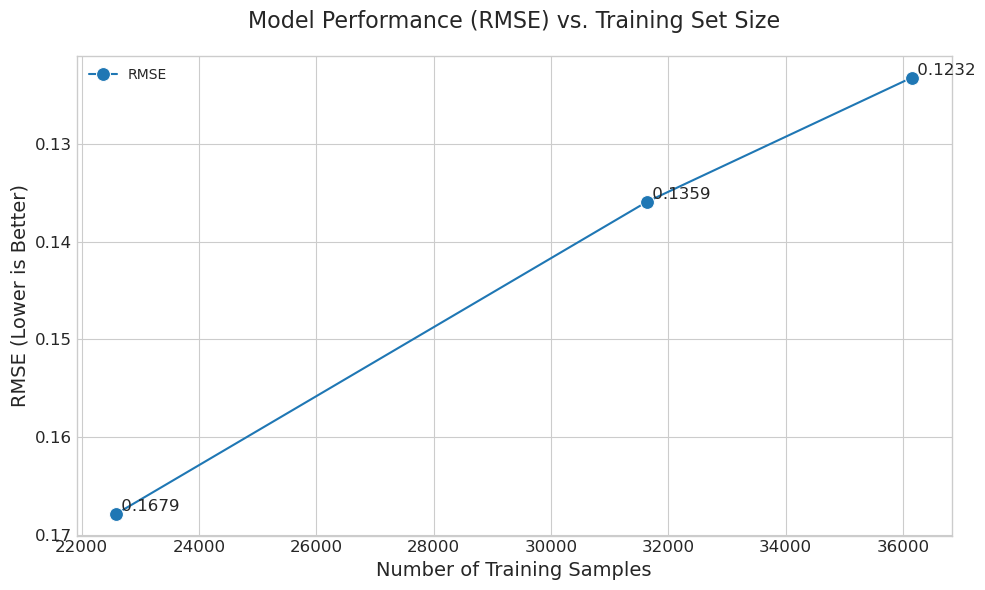

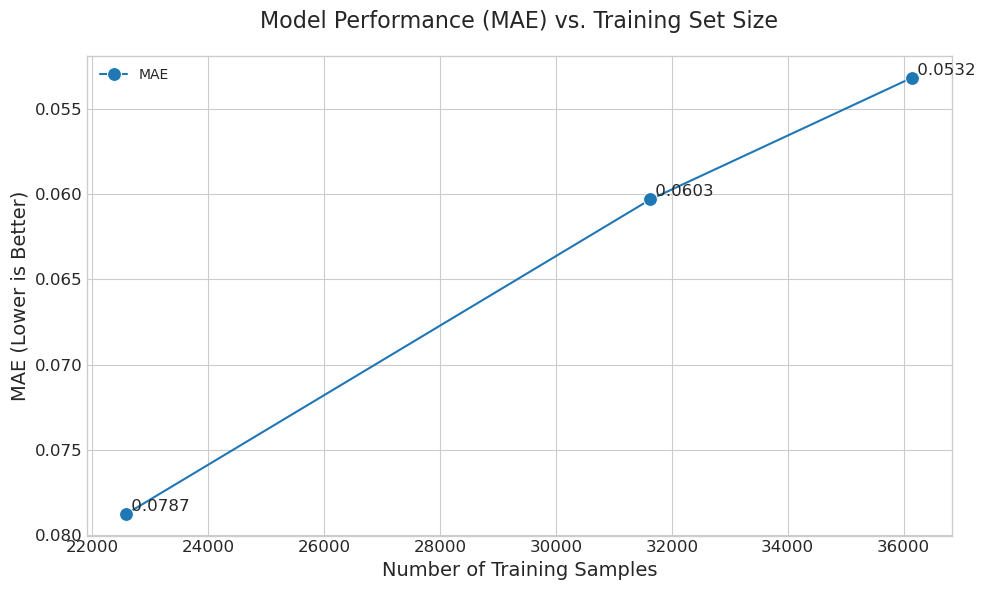

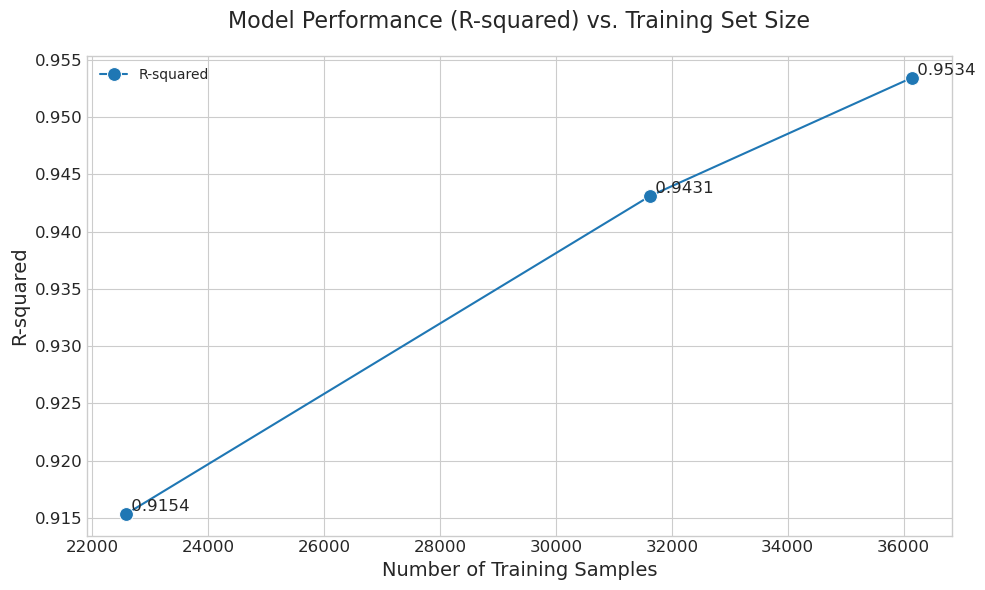

In [29]:
# ===================================================================
# FINAL CELL: Analysis & Visualization of Model Robustness
# ===================================================================
import mlflow
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Fetch the Data from MLflow ---
logger.info("--- Fetching sensitivity analysis results from MLflow ---")

EXPERIMENT_NAME = "Zomato_Prediction_v1_XGBoost"

# The Run ID from your screenshot for the 80/20 split champion
CHAMPION_RUN_ID = "6e9df2f0d7ac41f5b7d8fab3996deb1d"

# We will find the other two runs by name
ROBUSTNESS_RUN_NAMES = [
    "Robustness_Check_70_30_Split", 
    "Robustness_Check_50_50_Split"
]

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

# Fetch the main champion run by its unique ID
# Search for its name to get the correct column structure
champion_run_df = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string=f"attributes.run_name = 'Champion_XGBoost'",
    order_by=["start_time DESC"],
    max_results=1
)

# Fetch the other runs by name
list_of_robustness_runs = []
for run_name in ROBUSTNESS_RUN_NAMES:
    run_df = mlflow.search_runs(
        experiment_ids=[experiment.experiment_id],
        filter_string=f"attributes.run_name = '{run_name}'",
        order_by=["start_time DESC"],
        max_results=1
    )
    if not run_df.empty:
        list_of_robustness_runs.append(run_df)

# Combine all results into a single DataFrame
runs_df = pd.concat([champion_run_df] + list_of_robustness_runs, ignore_index=True)


# --- 2. Prepare the Data for Plotting ---
logger.info("--- Preparing data for visualization ---")

# <<< --- START OF FINAL FIX --- >>>
# The DataFrame column is named 'tags.mlflow.runName'.
results_df = runs_df[[
    "tags.mlflow.runName", # Correct column name for the run name
    "params.test_split_ratio", 
    "metrics.test_rmse", 
    "metrics.test_mae", 
    "metrics.test_r2"
]].copy()

results_df.rename(columns={
    "tags.mlflow.runName": "run_name", # Rename the tag to the simpler name
    "params.test_split_ratio": "test_split_ratio",
    "metrics.test_rmse": "RMSE",
    "metrics.test_mae": "MAE",
    "metrics.test_r2": "R-squared"
}, inplace=True)
# <<< --- END OF FINAL FIX --- >>>

results_df['test_split_ratio'].fillna(0.20, inplace=True)
results_df['test_split_ratio'] = results_df['test_split_ratio'].astype(float)

total_samples = len(df_master)
results_df['training_samples'] = ((1 - results_df['test_split_ratio']) * total_samples).astype(int)

results_df.sort_values(by='training_samples', ascending=False, inplace=True)

print("\n--- Consolidated Results ---")
display(results_df[['run_name', 'training_samples', 'RMSE', 'MAE', 'R-squared']].round(4))


# --- 3. Create the Stunning Visualizations ---
logger.info("--- Generating robustness plots ---")
metrics_to_plot = ["RMSE", "MAE", "R-squared"]
for metric in metrics_to_plot:
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(data=results_df, x='training_samples', y=metric, marker='o', markersize=10, ax=ax, label=metric)
    
    for index, row in results_df.iterrows():
        ax.text(row['training_samples'], row[metric], f" {row[metric]:.4f}", 
                horizontalalignment='left', verticalalignment='bottom', fontsize=12)

    ax.set_title(f"Model Performance ({metric}) vs. Training Set Size", fontsize=16, pad=20)
    ax.set_xlabel("Number of Training Samples", fontsize=14)
    ax.set_ylabel(metric, fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    if metric in ["RMSE", "MAE"]:
        ax.invert_yaxis()
        ax.set_ylabel(f"{metric} (Lower is Better)", fontsize=14)

    plt.tight_layout()
    plt.show()

In [32]:
# ===================================================================
# FINAL CELL: Explainable AI (XAI) with SHAP
# ===================================================================

# --- 1. Installation (run this once if you haven't already) ---
# !pip install shap

import shap
import mlflow
import xgboost as xgb
import pandas as pd
import numpy as np
import os

logger.info("--- Starting Explainable AI (XAI) analysis with SHAP ---")

# --- 2. Load the Definitive Champion Model from MLflow ---
CHAMPION_RUN_ID = "6e9df2f0d7ac41f5b7d8fab3996deb1d" 
logger.info(f"Loading champion pyfunc model from MLflow Run ID: {CHAMPION_RUN_ID}")

try:
    logged_model_uri = f"runs:/{CHAMPION_RUN_ID}/champion_model"
    
    # <<< --- START OF FIX --- >>>
    # Load the model as a generic PyFunc, which is how it was saved.
    loaded_pyfunc = mlflow.pyfunc.load_model(logged_model_uri)
    
    # Access the underlying pipeline from our custom wrapper
    # The _model_impl attribute gives us our DtypeEnforcingModel instance
    loaded_pipeline = loaded_pyfunc._model_impl.pipeline
    # <<< --- END OF FIX --- >>>
    
    logger.success("Champion pipeline loaded successfully from pyfunc wrapper.")
except Exception as e:
    logger.error(f"Failed to load model from MLflow. Please check the Run ID. Error: {e}")
    raise

# --- 3. Prepare Data for Explanation ---
logger.info("Preparing data with correct 'category' dtypes for explanation...")
y = df_master['rate']
X = df_master.drop(columns=['rate'] + cols_to_drop, errors='ignore')
for col in categorical_features:
    if col in X.columns: X[col] = X[col].astype('category')
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor = loaded_pipeline.named_steps['preprocessor']
xgb_model = loaded_pipeline.named_steps['regressor']
X_test_processed = preprocessor.transform(X_test_xgb)
logger.success("Test data has been preprocessed for SHAP analysis.")


# --- 4. Create Explainer and Calculate SHAP Values ---
logger.info("Creating SHAP TreeExplainer...")
explainer = shap.TreeExplainer(xgb_model)
logger.info("Calculating SHAP values for the test set... (this may take a moment)")
shap_values = explainer.shap_values(X_test_processed)
logger.success("SHAP values calculated successfully.")


# --- 5. Log All XAI Artifacts to a New MLflow Run ---
XAI_RUN_NAME = f"XAI_Analysis_{CHAMPION_RUN_ID[:8]}"
with mlflow.start_run(run_name=XAI_RUN_NAME):
    logger.info(f"Logging XAI artifacts to new MLflow run: '{XAI_RUN_NAME}'")
    mlflow.set_tag("Analysis Type", "SHAP Explainability")
    mlflow.set_tag("Champion Run ID", CHAMPION_RUN_ID)
    
    shap.summary_plot(shap_values, X_test_processed, show=False)
    plt.title("SHAP Summary Plot", fontsize=16); plt.tight_layout()
    mlflow.log_figure(plt.gcf(), "shap_summary_plot.png"); plt.close()
    logger.success("Logged SHAP summary plot.")
    
    force_plot_html_path = "shap_force_plot_first_prediction.html"
    shap.save_html(force_plot_html_path, shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_processed.iloc[0,:]))
    mlflow.log_artifact(force_plot_html_path, "interactive_plots")
    logger.success("Logged interactive SHAP force plot.")
    
    shap_values_path = "shap_values.npy"
    np.save(shap_values_path, shap_values)
    mlflow.log_artifact(shap_values_path)
    logger.success("Logged raw SHAP values array.")

logger.info("--- XAI Analysis Complete. Check the MLflow UI. ---")

2025-09-20 01:17:53 | INFO     | --- Starting Explainable AI (XAI) analysis with SHAP ---
2025-09-20 01:17:53 | INFO     | Loading champion pyfunc model from MLflow Run ID: 6e9df2f0d7ac41f5b7d8fab3996deb1d


2025-09-20 01:17:53 | ERROR    | Failed to load model from MLflow. Please check the Run ID. Error: Failed to download artifacts from path 'champion_model', please ensure that the path is correct.


MlflowException: Failed to download artifacts from path 'champion_model', please ensure that the path is correct.